# Results from Google Big Query: HackerNews
## https://github.com/HackerNews/API for fields definition

## Aim: What are the top 10 frequently used words to get a high score in HackerNews

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/jing/Desktop/GA/Project_GA/hn_story.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
by             10000 non-null object
score          10000 non-null int64
time           10000 non-null int64
title          10000 non-null object
type           10000 non-null object
url            279 non-null object
text           10000 non-null object
parent         0 non-null float64
deleted        0 non-null float64
dead           1849 non-null object
descendants    8151 non-null float64
id             10000 non-null int64
ranking        0 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1015.7+ KB


# Cleaning of Data

In [2]:
#deleted, ranking are all null. drop those columns.
df.drop(['deleted', 'ranking'], axis=1,inplace = True)

#parent's ids are irrelevant to predict scores
df.drop(['parent'], axis = 1, inplace = True)

#time is in unix, change it to mm/dd/yy hh:mm:ss 
df=df.set_index(pd.to_datetime(df['time'], unit='s'))
df.index.rename('GMT_time', inplace=True)

#dead is boolean. those null = False. transform it to 1 and 0
df['dead'].fillna(value=False, inplace  = True)
df[['dead']]=df[['dead']].astype(int)

#assume descendants null = 0
df['descendants'].fillna(value =0, inplace =True)

#add len of text to part of df
df['text_length'] = df['text'].str.len()
#creating column for hour when story is posted
df['post_hour'] = pd.DatetimeIndex(df.index).hour
df['post_hour'].fillna(value = df['post_hour'].mean(), inplace = True)
df['post_day'] = pd.DatetimeIndex(df.index).dayofweek #0 for monday
df['post_day'].fillna(value = df['post_day'].mean(), inplace = True)

# Visualisation

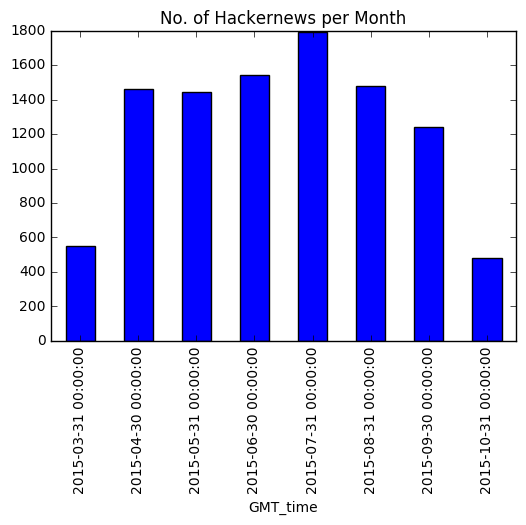

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

#which W has the most hackernews 
bar_chart=df['id'].groupby(pd.TimeGrouper("M")).count().plot(kind='bar', title='No. of Hackernews per Month')
bar_chart.x_label = 'Date'
bar_chart.y_label = 'Quantity'

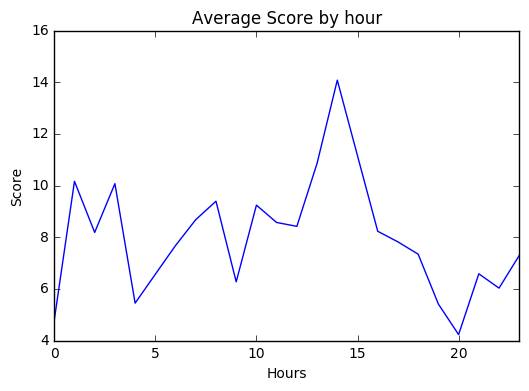

In [4]:
#which hour have the most post 
hour_chart = df['score'].groupby(df['post_hour']).mean().plot(kind ='line', title ='Average Score by hour')
hour_chart.set_xlabel('Hours')
hour_chart.set_ylabel('Score')

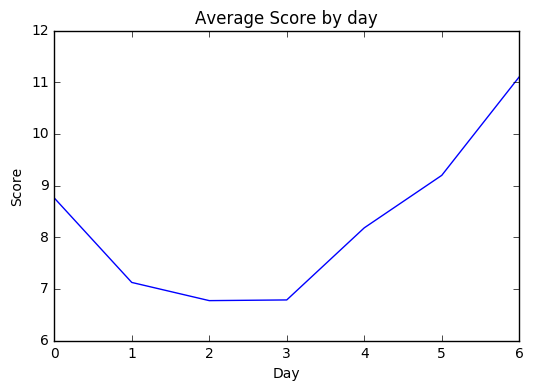

In [5]:
#which day have the most post 
day_chart = df['score'].groupby(df['post_day']).mean().plot(kind ='line', title ='Average Score by day')
day_chart.set_xlabel('Day') #0 is monday
day_chart.set_ylabel('Score')

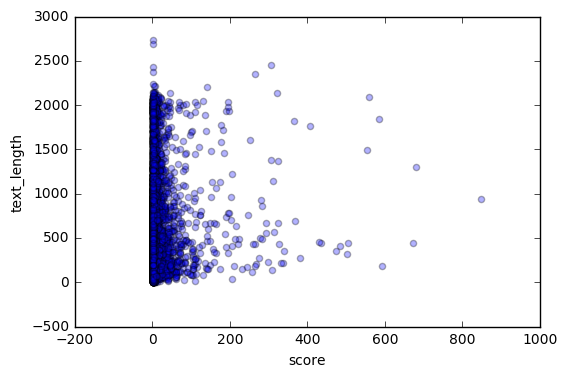

In [6]:
df.plot.scatter(x = 'score', y ='text_length',alpha =0.3)

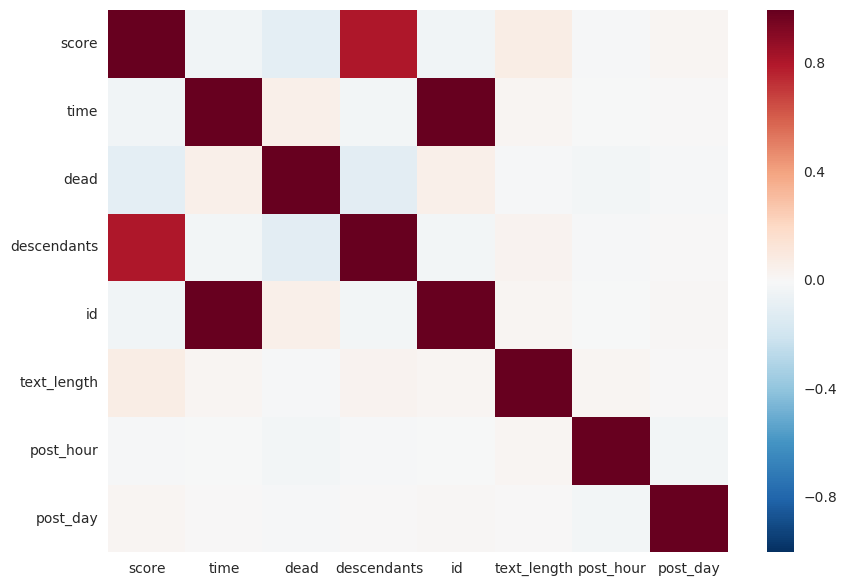

In [7]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df.corr())

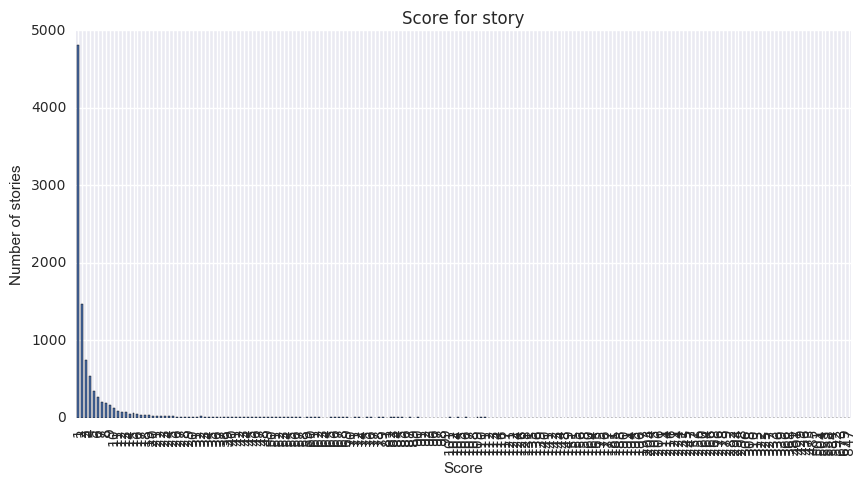

In [8]:
#groupby scores and count stories. check what is the most common score for a story
f, ax = plt.subplots(figsize=(10, 5))
score_chart = df['id'].groupby(df['score']).count().plot(kind ='bar',title='Score for story')
score_chart.set_xlabel('Score')
score_chart.set_ylabel('Number of stories')

## Need to normalise the score. Thanks Guojun!

## Normalize the Score base on:
### https://medium.com/hacking-and-gonzo/how-hacker-news-ranking-algorithm-works-1d9b0cf2c08d#.xea611fdv
### Score = (P-1) / (T+2)^G 
<p>where
<br>P = points of an item (and -1 is to negate submitters vote)
<br>T = time since submission (in hours)
<br>G = Gravity, defaults to 1.8 in news.arc

In [9]:
df['time_delta'] = df['time'].max() - df['time']
#group the time_delta column to the nearest hour since the algo uses the nearest hour
df['time_delta_hour'] = df['time_delta']/3600 
df['time_delta_hour'] = df['time_delta_hour'].apply(np.floor).astype(int)

def calculate_reverse_score(score, time_delta_hour, gravity=1.8):
    #Return normalize score
    #Dangerous numbers too big
    return (score * pow((time_delta_hour+2), gravity) + 1)

df['normalized_score'] = np.vectorize(calculate_reverse_score)(df['score'], df['time_delta_hour'])

#normalized: 0 to 100
df['normalized_score2'] = ((df['normalized_score'] - df['normalized_score'].min())/df['normalized_score'].max()) * 100

#To see top 50 
df.sort_values(by='normalized_score2', ascending=True).head(50)

,by,score,time,title,type,url,text,dead,descendants,id,text_length,post_hour,post_day,time_delta,time_delta_hour,normalized_score,normalized_score2
GMT_time,,,,,,,,,,,,,,,,,
2015-10-13 06:57:17,sliekasbekelniu,1,1444719437,Ask HN: Could you recommend Computer basics co...,story,NaN,"Hi, there HN community,<p>there are a lot of p...",0,0.0,10378921,617,6,1,0,0,4.482202,0.000000e+00
2015-10-13 06:49:29,hn-growth,4,1444718969,Ask HN: Can you shed some light on calculating...,story,NaN,I&#x27;m looking for some help with growth rat...,0,0.0,10378901,1127,6,1,468,0,14.928809,4.363922e-07
2015-10-13 00:11:07,killingsickness,1,1444695067,Help us end viruses (www.killingsickness.com),story,NaN,No one person is exempt from catching any type...,1,0.0,10377672,166,0,1,24370,6,43.224253,1.618394e-06
2015-10-13 04:49:37,throwaway321564,4,1444711777,Ask HN: How to decide on Enterprise pricing,story,NaN,I have a saas app in the $12-$29&#x2F;month r...,0,2.0,10378603,504,4,1,7660,2,49.502930,1.880677e-06
2015-10-13 01:23:10,Oggle,2,1444699390,Travel assistant on demand,story,NaN,What do you guys think of this? It&#x27;s an i...,0,0.0,10377894,243,1,1,20047,5,67.405870,2.628547e-06
2015-10-12 21:09:40,jseeff,1,1444684180,We all know that ten lawyers at the bottom of,story,NaN,We all know that ten lawyers at the bottom of ...,1,0.0,10376978,286,21,0,35257,9,75.904314,2.983558e-06
2015-10-12 21:20:08,r-dc,1,1444684808,Ask HN: How can I finish my website?,story,NaN,I&#x27;m developing a Ruby on Rails ecommerce ...,0,1.0,10377018,329,21,0,34629,9,75.904314,2.983558e-06
2015-10-12 20:52:02,kaustavha,1,1444683122,Documentation for luvit,story,NaN,Documentation for the luvit project \naka\nHow...,0,0.0,10376893,471,20,0,36315,10,88.604465,3.514089e-06
2015-10-12 20:46:11,tabulatouch,1,1444682771,"Is Windows improving, and MacOs failing?",story,NaN,Ever since Windows 7 I was able to get better ...,0,2.0,10376864,449,20,0,36666,10,88.604465,3.514089e-06


# Remove stop word and strange characters from text

In [11]:
import re

#need to remove entire word with weird character....
df['text_nourl'] = df['text'].map(lambda x: re.sub("http\S+", '', x))
df['text_nohtml'] = df['text_nourl'].map(lambda x: re.sub('<p>','',x))
df['text_nohtml2'] = df['text_nohtml'].map(lambda x: re.sub('&#x27;','',x))
df['text_nodigits'] = df['text_nohtml2'].map(lambda x: re.sub('\d\S+', '',x))
df['text_clean'] = df['text_nodigits'].map(lambda x: re.sub('[^A-Za-z ]+','', x))

# Text analysis using Naive Bayes

In [12]:
#ngram text analysis on 10000 text. 
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer(ngram_range=(1,3), stop_words = 'english')
df_text = df[['score', 'text_clean', 'id']].copy()
CV.fit(df_text['text_clean'])
X_count = CV.transform(df_text['text_clean'])
Y = df_text['score']


In [13]:
# from occurance to frequency
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer().fit(X_count)
X = tf_transformer.transform(X_count)

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, random_state =3)


In [14]:
def accuracy_report(_clf):
    training_accuracy = _clf.score(xtrain, ytrain)
    test_accuracy = _clf.score(xtest, ytest)
    print "Accuracy on test data: %0.2f%%" % (100 * test_accuracy)
    print "Accuracy on training data: %0.2f%%" % (100 * training_accuracy)

In [15]:
from sklearn.naive_bayes import MultinomialNB
print "MultinomialNB:"
clf_m = MultinomialNB().fit(xtrain, ytrain)
accuracy_report(clf_m)

MultinomialNB:
Accuracy on test data: 47.80%
Accuracy on training data: 48.27%


In [16]:
from sklearn.naive_bayes import BernoulliNB
print "BernoulliNB:"
clf_b = BernoulliNB().fit(xtrain, ytrain)
accuracy_report(clf_b)

BernoulliNB:
Accuracy on test data: 47.76%
Accuracy on training data: 48.93%


In [17]:
from sklearn.linear_model import LogisticRegression
print "Logistic Regression:"
clf_lr = LogisticRegression(penalty ='l2', C=1e42).fit(xtrain, ytrain)
accuracy_report(clf_lr)

Logistic Regression:
Accuracy on test data: 44.88%
Accuracy on training data: 99.23%


In [18]:
from sklearn.linear_model import SGDClassifier
print 'SGDClassifier:'
clf_s= SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42).fit(xtrain, ytrain)
accuracy_report(clf_s)

SGDClassifier:
Accuracy on test data: 47.28%
Accuracy on training data: 82.89%


# Predict top 10 keywords for good score

In [39]:
# predict score for test set
# sort the top 10% highest score stories
# get the top 10 frequent keywords

#because the accuracy of the models are so low... i cant predict anything meaningful.

scores = clf_m.predict(xtest)
xtest
#zip(scores, df['id'][df['text_clean']== xtest])

<2500x41038 sparse matrix of type '<type 'numpy.int64'>'
	with 25238 stored elements in Compressed Sparse Row format>

# Title analysis using Naive Bayes

In [20]:
df['title_clean'] = df['title'].map(lambda x: re.sub('\d\S+', '',x))

In [21]:
#ngram text analysis on 10000 text. 
from sklearn.feature_extraction.text import CountVectorizer

CV_T = CountVectorizer(ngram_range=(1,2), stop_words='english')
df_text = df[['score', 'title_clean']].copy()
CV_T.fit(df_text['title_clean'])
X = CV_T.transform(df_text['title_clean'])
Y = df_text['score']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, random_state =3)

In [23]:
from sklearn.naive_bayes import MultinomialNB
print "MultinomialNB:"
clf_m = MultinomialNB().fit(xtrain, ytrain)
accuracy_report(clf_m)

MultinomialNB:
Accuracy on test data: 44.84%
Accuracy on training data: 65.48%


In [24]:
from sklearn.naive_bayes import BernoulliNB
print "BernoulliNB:"
clf_b = BernoulliNB().fit(xtrain, ytrain)
accuracy_report(clf_b)

BernoulliNB:
Accuracy on test data: 47.80%
Accuracy on training data: 48.28%


In [25]:
from sklearn.linear_model import LogisticRegression
print "Logistic Regression:"
clf_lr = LogisticRegression(penalty ='l2', C=1e42).fit(xtrain, ytrain)
accuracy_report(clf_lr)

Logistic Regression:
Accuracy on test data: 36.80%
Accuracy on training data: 99.27%


In [26]:
from sklearn.linear_model import SGDClassifier
clf_s= SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42).fit(xtrain, ytrain)
accuracy_report(clf_s)

Accuracy on test data: 40.68%
Accuracy on training data: 88.37%
